# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [1]:
!git clone https://github.com/DataHow/analytics-course-scripts.git

Cloning into 'analytics-course-scripts'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 394 (delta 96), reused 100 (delta 42), pack-reused 236
Receiving objects: 100% (394/394), 17.68 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [151]:
# import libaries
import pandas as pd
import numpy as np
import scipy
import copy
import importlib  
import scipy.integrate
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, validation_curve, RepeatedKFold, cross_validate
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import LinearSVR, SVR
import warnings
warnings.filterwarnings("ignore")

# import custom modules
simulator = importlib.import_module("analytics-course-scripts.scripts.modules.simulator")
modelhelpers = importlib.import_module("analytics-course-scripts.scripts.modules.modelhelpers")

# Import or Generate Dataset

In the beginning of each notebook you can make a decision whether you run the notebooks with already pre-generated runs which will be just imported or you will generate your own doe dataset from insilico model. For further information about the process emulator for cell culture fed-batch processes, check the script "00_Process_Characterization.ipynb" or the Powerpoint presentation "Simplified InSilico Model.pptx".

* For dataset import set `select_dataset_source = "import"`.
* For generating data set `select_dataset_source = "generate"`.

For first time running the notebook, we recommend choosing the "import" option.

 

In [3]:
""" Select dataset source, one of (import, generate) """
DATASET_SOURCE = "import"

In [4]:
if DATASET_SOURCE == "import":
    # Define filename to import
    FILENAME = "owu.csv"
    FILEPATH = "/content/analytics-course-scripts/scripts/datasets/"
    # Import OWU data
    doe = pd.read_csv(FILEPATH+FILENAME.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    owu = pd.read_csv(FILEPATH+FILENAME,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(int(len(owu)/15))),list(range(15))], names=["run","time"])
    # Import OWU Test data
    FILENAME = "owu_test.csv"
    doe_test = pd.read_csv(FILEPATH+FILENAME.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    owu_test = pd.read_csv(FILEPATH+FILENAME,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu_test.index = pd.MultiIndex.from_product([list(range(int(len(owu)/15))),list(range(15))], names=["run","time"])

In [5]:
if DATASET_SOURCE == "generate":
    # DOE Dataset definition (variable = [lower bound, upper bound]) 
    # Model parameters: Dictate the behaviour of the cell process
    MU_G_MAX = 0.05;
    MU_D_MAX = 0.025;
    K_G_GLC  = 1;
    K_I_LAC  = 30;
    K_D_LAC  = 50;
    K_GLC    = 0.04;
    K_LAC    = 0.06;
    K_PROD   = 1;
    # Process parameters: Conditions at which process is run
    FEED_START = [1, 4]
    FEED_END = [8, 12]
    GLC_FEED_RATE = [5, 20]
    GLC_0 = [10, 80.0]
    VCD_0 = [0.1, 1.0]
    # Number of experiments to generate
    NUM_RUNS = 40
    # Filename and filepath for the dataset 
    FILENAME = "owu.csv"
    FILEPATH = "/content/"
    # Collect parameters to dictionary
    VAR_LIMS = {"mu_g_max":MU_G_MAX, "mu_d_max": MU_D_MAX, "K_g_Glc" : K_G_GLC, "K_I_Lac" : K_I_LAC, "K_d_Lac" : K_D_LAC, "k_Glc" : K_GLC, "k_Lac" : K_LAC, "k_Prod" : K_PROD,
        "feed_start" : FEED_START,"feed_end" : FEED_END, "Glc_feed_rate" : GLC_FEED_RATE, "Glc_0" : GLC_0, "VCD_0" : VCD_0}
    # Generate Dataset
    data = simulator.generate_data(VAR_LIMS, NUM_RUNS, FILENAME)
    # Import DOE
    doe = pd.read_csv(FILEPATH+FILENAME.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    # Import OWU
    owu = pd.read_csv(FILEPATH+FILENAME,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(NUM_RUNS)),list(range(15))], names=["run","time"])

Generate regression targets for our data (Titer and Aggegates)

In [10]:
# Size of test set (up to 50)
NUM_TEST =30
owu_test = owu_test.loc[0:NUM_TEST,slice(None)]
doe_test = doe_test.loc[0:NUM_TEST]
# Rename columns
doe.columns = ["F:start","F:end","F:rate","GLC:0","VCD:0"]
doe_test.columns = ["F:start","F:end","F:rate","GLC:0","VCD:0"]
# Train set
bwu = simulator.generate_bwu(owu)
y1 = simulator.generate_y(bwu,return_aggr=False)
y2 = simulator.generate_y(bwu,return_aggr=True)
# Test set
bwu_test = simulator.generate_bwu(owu_test)
y1_test = simulator.generate_y(bwu_test,return_aggr=False)
y2_test = simulator.generate_y(bwu_test,return_aggr=True)

# Varying the Dataset

In [84]:
""" Normalize data """
USE_NORMALIZATION = True
""" Ploynomial degree of features """
USE_POLYDEGREE = 2
""" Add only interaction between features"""
USE_INTERACTIONSONLY = False

In [85]:
# Define pipeline
poly_features = PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)
standard_scaler = StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)
reg_model = LassoCV()
pipe = Pipeline([('features', poly_features), 
                 ('scaler', standard_scaler),
                 ('model', reg_model)])
# Fit model
X = doe
y = y2
pipe.fit(X,y)
# Feature Names & Coefficients
X_columns = poly_features.get_feature_names_out()
X_preproc = pipe[:-1].transform(X) 
coefs = reg_model.coef_
# Plot coefs
fig = px.bar(x=list(X_columns), y=coefs.reshape(-1), title="Model coefficients",labels={'x':"Variables", 'y':"Estimated Coefficients"})
fig.update_layout(xaxis_tickangle=90)
fig.show()


## CV Subsets

In [86]:
# Plot Variation in Coefficient across Repeated Cross Validation
CV = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
variation_pipe = cross_validate(pipe,X,y,cv=CV,return_estimator=True)
variation_coef = pd.DataFrame([est[-1].coef_.reshape(-1) for est, (train_idx, _) in zip(variation_pipe["estimator"], CV.split(X,y))],columns=X_columns)
fig = px.box(variation_coef,points='all')
fig.update_layout(xaxis_tickangle=90,title="Variation in Coefficients",yaxis_title='Coefficient Value',xaxis_title='Variables')
fig.show()


In [87]:
# Predict on test set
X_test = doe_test
y_test = y2_test
variation_pred = pd.DataFrame([est.predict(X_test) for est, (train_idx, _) in zip(variation_pipe["estimator"], CV.split(X,y))])
fig = go.Figure()
for i in range(len(y_test)):
    fig.add_trace(go.Box(y=variation_pred.iloc[:,i],name=i,boxpoints='all',marker_color = px.colors.qualitative.Plotly[0]))
    fig.add_trace(go.Box(y=y_test.values[i], name=i,marker=dict(color=px.colors.qualitative.Plotly[1])))
fig.update_layout(title="Variation in Predictions (blue: prediction, red: observation)",showlegend=False,xaxis_title="Test Set Observation Number",yaxis_title="Predicted Value",)
fig.show()

# Varying the Models

Another option to obtain ensembles are to vary models, ie underlying assumptions about the data.

## Averaging predictions

Here we simply average the results of all 4 possible models

In [93]:
# Define different models
reg1 = Pipeline([('features', PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)), 
                 ('scaler', StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)),
                 ('model', LassoCV())])
reg2 = Pipeline([('features', PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)), 
                 ('scaler', StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)),
                 ('model', RidgeCV())])
reg3 = Pipeline([('features', PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)), 
                 ('scaler', StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)),
                 ('model', RandomForestRegressor())])
reg4 = Pipeline([('features', PolynomialFeatures(degree=USE_POLYDEGREE, interaction_only=USE_INTERACTIONSONLY,include_bias=False)), 
                 ('scaler', StandardScaler(with_mean=USE_NORMALIZATION, with_std=USE_NORMALIZATION)),
                 ('model', SVR())])
# Train models
models = [reg1,reg2,reg3,reg4]
for reg in models:
    reg.fit(X,y)
# Average predictions
reg_avg = VotingRegressor([("Lasso", reg1), ("Ridge", reg2), ("RF", reg3), ("SVR", reg4)])
reg_avg.fit(X,y)
# Obtain predictions
preds = [reg_avg.predict(X_test).reshape(-1)]
for reg in models:
    preds.append(reg.predict(X_test).reshape(-1))
# Obtain RMSE
rmses = []
for i in range(len(preds)):
    rmses.append(round(mean_squared_error(y_test, preds[i],squared=False) / np.std(np.array(y_test)),3))
xgrid=list(range(NUM_TEST))
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=y_test.values.flatten(),name='Observations',mode='markers',marker=dict(symbol='square',size=10,color=px.colors.qualitative.Plotly[1])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[0],name=f'Average (rmse {rmses[0]})',mode='markers',marker=dict(symbol='star',size=10,color=px.colors.qualitative.Plotly[0])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[1],name=f'Lasso (rmse {rmses[1]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[2])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[2],name=f'Ridge (rmse {rmses[2]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[7])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[3],name=f'RF (rmse {rmses[3]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[4])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[4],name=f'SVR (rmse {rmses[4]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[9])))
fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = xgrid),xaxis_title="Test Set Observation Number",yaxis_title="Predicted Value",title='Variation in Prediction across Models')
fig.show()

## Stacking models


It is sometimes tedious to find the model which will best perform on a given dataset. Stacking provide an alternative by combining the outputs of several learners, without the need to choose a model specifically. The performance of stacking is usually close to the best model and sometimes it can outperform the prediction performance of each individual model.

Here, we combine 4 learners (linear and non-linear) and use a ridge regressor to combine their outputs together.


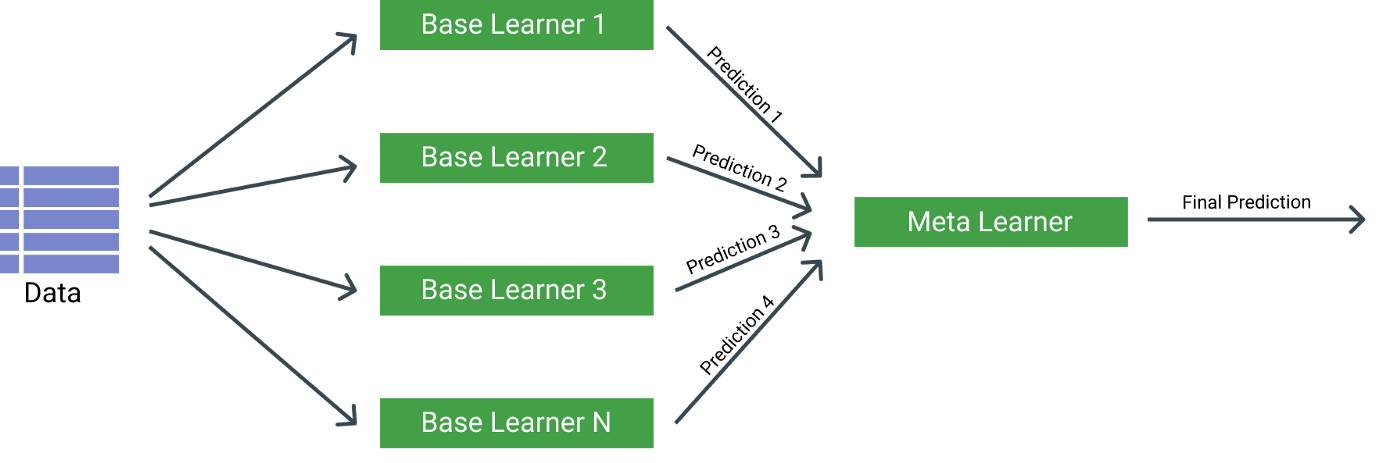

In [104]:
reg_stack = StackingRegressor(estimators=[("Lasso", reg1), ("Ridge", reg2), ("RF", reg3), ("SVR", reg4)], final_estimator=LassoCV())
reg_stack.fit(X,y)
# Obtain predictions & metric
preds.append(reg_stack.predict(X_test).reshape(-1))
rmses.append(round(mean_squared_error(y_test, preds[-1],squared=False) / np.std(np.array(y_test)),3))
# Plot predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=y_test.values.flatten(),name='Observations',mode='markers',marker=dict(symbol='square',size=10,color=px.colors.qualitative.Plotly[1])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[-1],name=f'Stacking (rmse {rmses[-1]})',mode='markers',marker=dict(symbol='star',size=10,color=px.colors.qualitative.Plotly[0])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[1],name=f'Lasso (rmse {rmses[1]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[2])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[2],name=f'Ridge (rmse {rmses[2]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[7])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[3],name=f'RF (rmse {rmses[3]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[4])))
fig.add_trace(go.Scatter(x=xgrid,y=preds[4],name=f'SVR (rmse {rmses[4]})',mode='markers',marker=dict(size=8,color=px.colors.qualitative.Plotly[9])))
fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = xgrid),xaxis_title="Test Set Observation Number",yaxis_title="Predicted Value",title='Variation in Prediction across Models')
fig.show()


# Prediction Intervals

A prediction interval is calculated as some combination of the estimated **variance of the model** and the **variance of the outcome variable**.

Prediction intervals are easy to describe, but difficult to calculate in practice. In simple cases like linear regression, we can estimate the prediction interval directly.

In the cases of nonlinear regression algorithms, such as artificial neural networks, random forrests, it is a lot more challenging and requires the choice and implementation of specialized techniques. General techniques such as the bootstrap resampling method can be used, but are computationally expensive to calculate.

The following list summarizes some popular methods that can be used for prediction uncertainty for linear or nonlinear machine learning models:


* The Parametric Method, using estimated statistics from mean-variance estimation.
* The Bootstrap Method, using data resampling and developing an ensemble of models.
* The Bayesian Method, from Bayesian modeling and statistics.
* The Quantile Regressions, by directly learning the quantiles.
* others like dela-method, etc.

We can make the calculation of a prediction interval concrete with a worked example in the next section. We compare only the parametric method to bootsrap method.

In [ ]:
def prediction_interval(model, X_train, y_train, x0, alpha: float = 0.05):
  ''' Compute a prediction interval around the model's prediction of x0. '''

  # Number of training samples
  n = X_train.shape[0]

  # The authors choose the number of bootstrap samples as the square root
  # of the number of samples
  nbootstraps = np.sqrt(n).astype(int)

  # Compute the m_i's and the validation residuals
  bootstrap_preds, val_residuals = np.empty(nbootstraps), []
  for b in range(nbootstraps):
    train_idxs = np.random.choice(range(n), size = n, replace = True)
    val_idxs = np.array([idx for idx in range(n) if idx not in train_idxs])
    model.fit(X_train[train_idxs, :], y_train[train_idxs])
    preds = model.predict(X_train[val_idxs])
    val_residuals.append(y_train[val_idxs] - preds)
    bootstrap_preds[b] = model.predict(x0)
  bootstrap_preds -= np.mean(bootstrap_preds)
  val_residuals = np.concatenate(val_residuals)

  # Compute the prediction and the training residuals
  model.fit(X_train, y_train)
  preds = model.predict(X_train)
  train_residuals = y_train - preds

  # Take percentiles of the training- and validation residuals to enable
  # comparisons between them
  val_residuals = np.percentile(val_residuals, q = np.arange(100))
  train_residuals = np.percentile(train_residuals, q = np.arange(100))

  # Compute the .632+ bootstrap estimate for the sample noise and bias
  no_information_error = np.mean(np.abs(np.random.permutation(y_train) - \
    np.random.permutation(preds)))
  generalisation = np.abs(val_residuals.mean() - train_residuals.mean())
  no_information_val = np.abs(no_information_error - train_residuals)
  relative_overfitting_rate = np.mean(generalisation / no_information_val)
  weight = .632 / (1 - .368 * relative_overfitting_rate)
  residuals = (1 - weight) * train_residuals + weight * val_residuals

  # Construct the C set and get the percentiles
  C = np.array([m + o for m in bootstrap_preds for o in residuals])
  qs = [100 * alpha / 2, 100 * (1 - alpha / 2)]
  percentiles = np.percentile(C, q = qs)

  return percentiles[0], model.predict(x0), percentiles[1]

## Bootstrapp Prediction Interval


A robust way to calculate confidence intervals for machine learning algorithms is to use the bootstrap. This is a general technique for estimating statistics that can be used to calculate empirical prediction intervals, regardless of the distribution of predicted data (e.g. non-Gaussian)

 The algorithm above for producing these intervals uses bootstrapping and was introduced in [Kumar and Srivastava (2012)](https://ntrs.nasa.gov/citations/20130014367)

### Linear Model Example

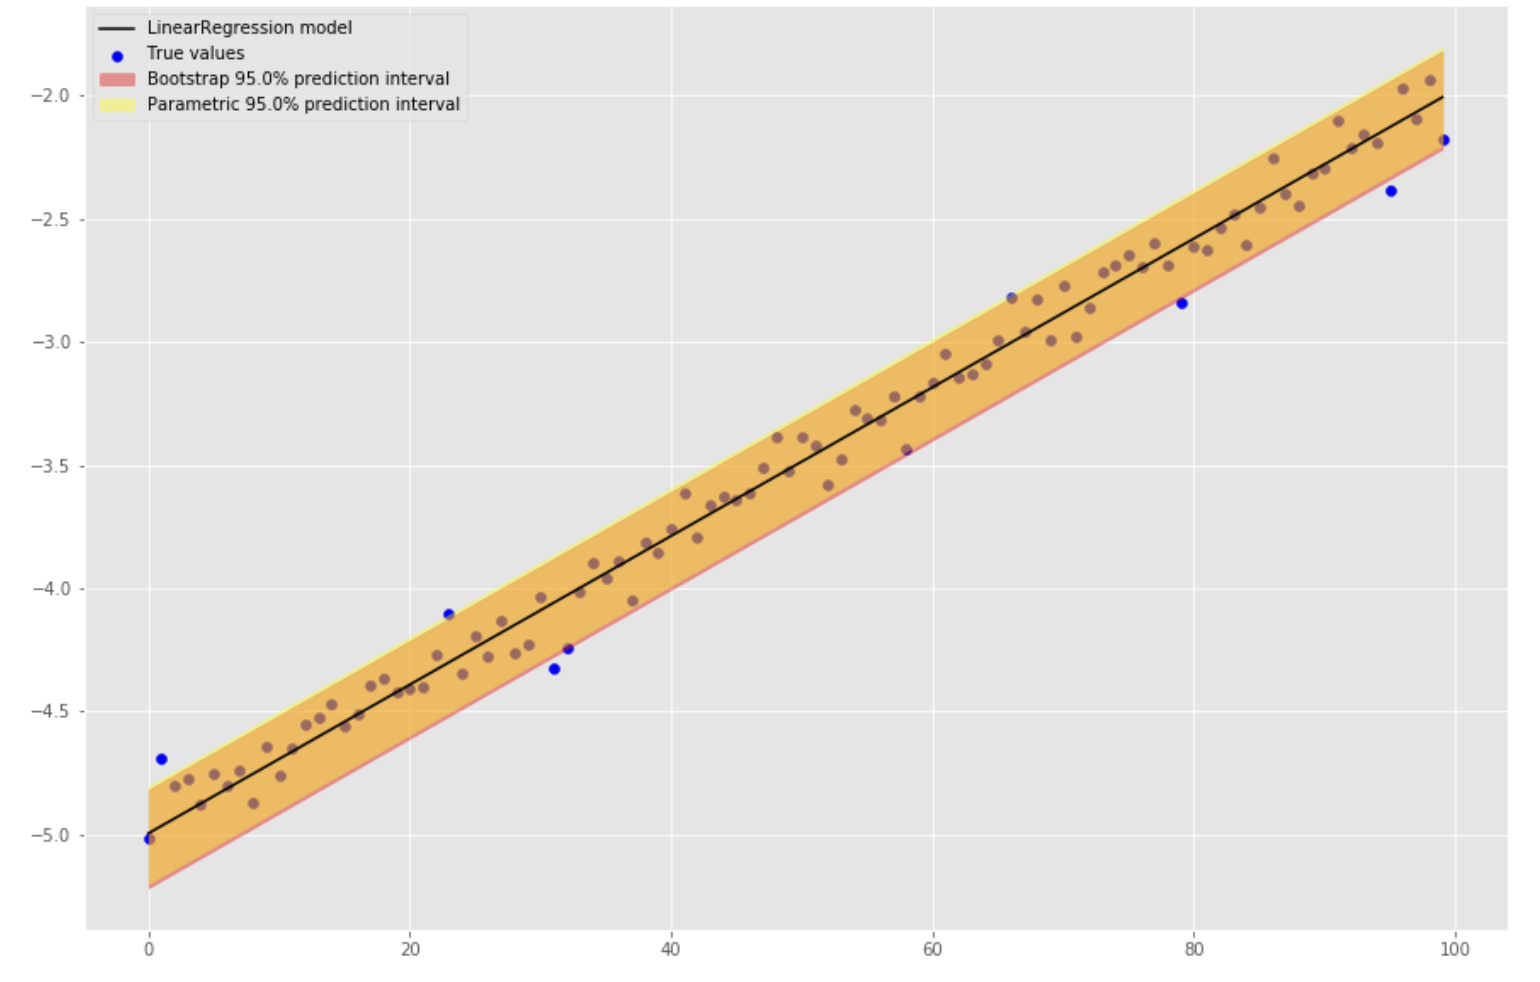

### Linear Model with Non-gaussian Errors 

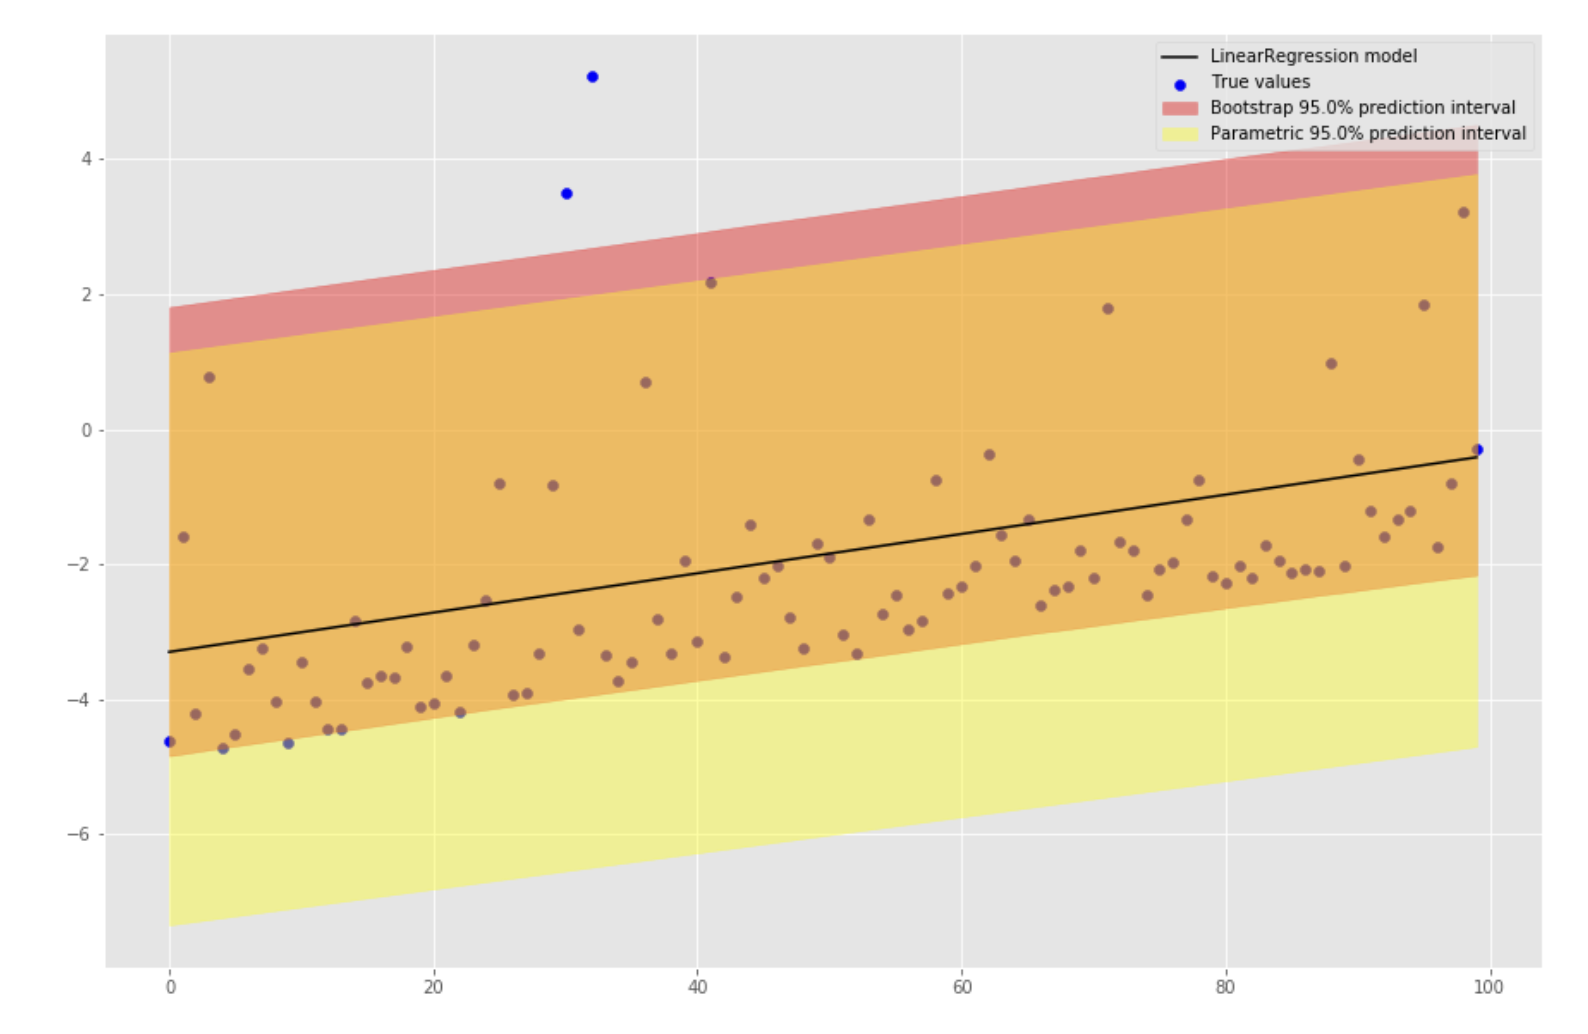

### Nonlinear Model 

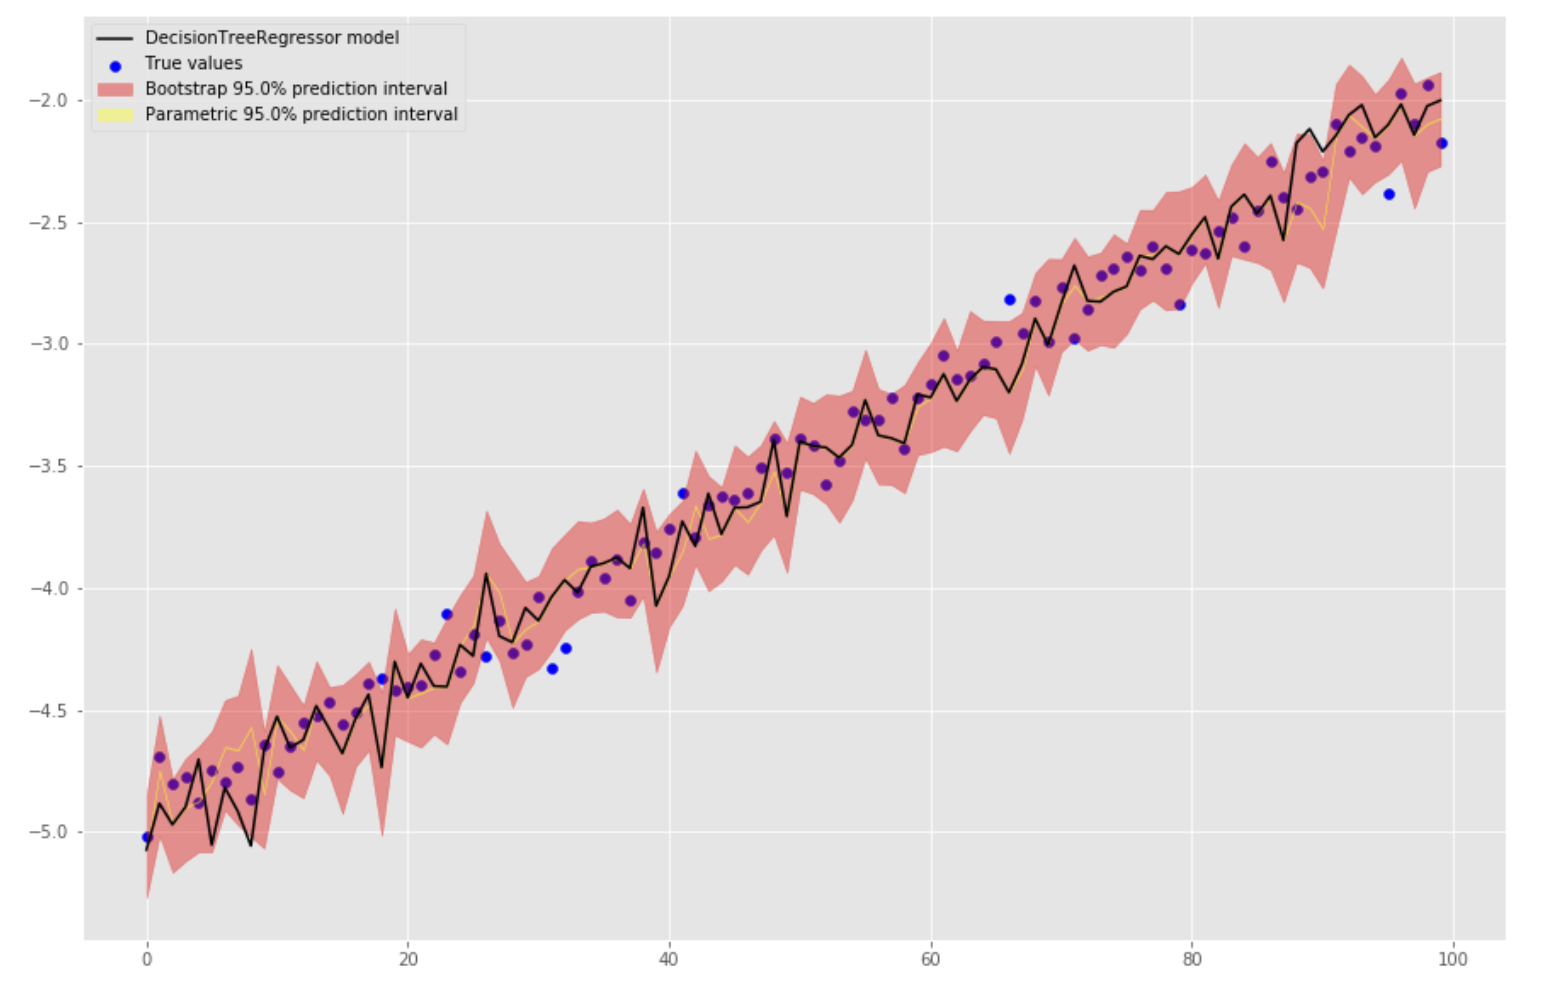